### Sparse Convolutional Attention Denoising Autoencoder (SCADA). REDUCED

En este cuaderno se explora una modificación en autoencoders, basándonos en el autoencoder del modelo SDCA, el uso de autoencoders con mecanismos de atención para la imputación de valores faltantes. Los autoencoders son redes neuronales diseñadas para aprender una representación comprimida de los datos y luego reconstruir la información original. Incorporar un mecanismo de atención permite al modelo enfocarse en las características más importantes, mejorando su capacidad para imputar datos de manera precisa.

En este caso se usa el conjunto de datos GRANDE (28220 columnas) para ver que resultados se obtienen con todos datos.

Los objetivos principales de este cuaderno son:
- Utilizar autoencoders con atención para reconstruir datos faltantes y aprender representaciones robustas de los datos incompletos.
- valuar el rendimiento del autoencoder en la imputación bajo diferentes niveles de valores faltantes.
- Comparar este enfoque con métodos alternativos: XGBoost, KNN , RF, SDCA

Descripción del enfoque:
- Codificación y decodificación: El autoencoder aprende una representación comprimida de los datos y luego reconstruye los valores faltantes en las características.
- Atención: El mecanismo de atención ajusta la importancia de las características en el proceso de imputación, mejorando la precisión de la reconstrucción.
- Evaluación: Se mide la capacidad del autoencoder para imputar correctamente los valores faltantes CON DISTINTPOS PORCENTAJES DE PÉRDIDA.

### attention autoencoder con TODOS LOS DATOS

In [1]:
#Importar librerias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import zipfile
import builtins
from tensorflow.keras.utils import to_categorical

In [2]:
# Hiperparámetros
batch_size = 32
lr = 1e-3
epochs = 10
kr = 1e-4  # Regularización L1
drop_prec = 0.25  # Dropout

In [3]:
# Cargar y procesar los datos, en este caso se coge el dataset grande que hay que descomprimir primero

def unzip(archivo_zip, variable_name):
    """
    Extrae y carga el contenido del único archivo dentro de un ZIP en una variable global.
    
    Parámetros:
    - archivo_zip: Ruta al archivo ZIP.
    - variable_name: Nombre de la variable global donde se guardará el DataFrame.
    """
    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        # Obtiene directamente el primer (y único) archivo
        file_name = zip_ref.namelist()[0]
        with zip_ref.open(file_name) as txt_file:
            # Leer el archivo como un DataFrame de pandas
            df = pd.read_csv(txt_file, sep='\t', index_col=0)
            
            # Asignar el DataFrame a una variable global con el nombre proporcionado
            builtins.__dict__[variable_name] = df

In [4]:

# path de descompresión
zip_file_train= '../data/raw/yeast_genotype_train.txt.zip'
# Llamar a la función para descomprimir y guardar los DataFrames en variable globale
unzip(zip_file_train, 'df_train') 

In [5]:

df_onehot = tf.keras.utils.to_categorical(df_train)
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

In [6]:

# Dimensiones de entrada
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
input_shape = (feature_size, inChannel)

# Codificador con atención
inputs = Input(shape=input_shape)
inputs

<KerasTensor shape=(None, 28220, 3), dtype=float32, sparse=False, name=keras_tensor>

In [7]:
# Capas convolucionales del encoder
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)

# Mecanismo de atención
def attention_1d(inputs):
    # Capa densa para generar los pesos de atención
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Multiplicar las activaciones convolucionales por los pesos de atención
    attention = Multiply()([inputs, attention])
    return attention

# Aplicar la atención después del encoder
x = attention_1d(x)

In [8]:
# Decodificador convolucional
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
outputs = Conv1D(inChannel, 5, activation='softmax', padding='same')(x)


In [9]:
# Definir el modelo
attention_model = Model(inputs, outputs)

In [10]:
# Compilar el modelo
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28220, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28220, 32) │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 14110, 32) │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14110, 32) │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 14110, 64) │     10,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 7055, 64)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7055, 64)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 7055, 128) │     41,088 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7055, 128) │     16,512 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7055, 128) │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 7055, 64)  │     41,024 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 14110, 64) │          0 │ conv1d_3[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 14110, 32) │     10,272 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_1     │ (None, 28220, 32) │          0 │ conv1d_4[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 28220, 3)  │        483 │ up_sampling1d_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,195 (469.51 KB)

 Trainable params: 120,195 (469.51 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

# Definir DataGenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [12]:

# Generacion data
train_generator = DataGenerator(batch_size=batch_size, x_dataset=train_X, missing_perc=0.1)
valid_generator = DataGenerator(batch_size=batch_size, x_dataset=valid_X, missing_perc=0.1)


In [13]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping call back con val_loss monitoring
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [14]:
attention_model_train = attention_model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,
    callbacks= [EarlyStopping]
    
)

Epoch 1/10


/Users/celiacabello/miniconda3/envs/TFM/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 873ms/step - accuracy: 0.6312 - loss: 1.0511 - val_accuracy: 0.9993 - val_loss: 0.1154
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 885ms/step - accuracy: 0.9982 - loss: 0.0993 - val_accuracy: 0.9993 - val_loss: 0.0633
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 865ms/step - accuracy: 0.9981 - loss: 0.0584 - val_accuracy: 0.9994 - val_loss: 0.0436
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 885ms/step - accuracy: 0.9981 - loss: 0.0421 - val_accuracy: 0.9995 - val_loss: 0.0337
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 914ms/step - accuracy: 0.9982 - loss: 0.0333 - val_accuracy: 0.9993 - val_loss: 0.0275
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 922ms/step - accuracy: 0.9984 - loss: 0.0273 - val_accuracy: 0.9994 - val_loss: 0.0230
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 78s 890ms/step - accuracy: 0.9985 - loss: 0.0231 - val_accuracy: 0.9994 - val_loss: 0.0197
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 919ms/step - accuracy: 0.9986 - loss: 0.0201 - val_accuracy: 0.999

### plotting

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_9409/2942292309.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")


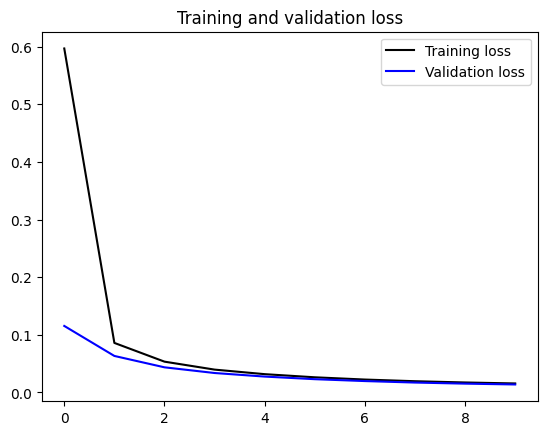

In [15]:
# plot loss 
loss = attention_model_train.history['loss']
val_loss = attention_model_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_9409/3539571467.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_9409/3539571467.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")


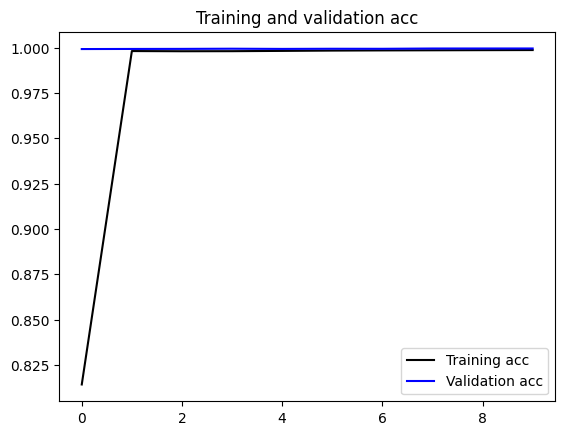

In [16]:

# plot accuracy 
print(attention_model_train.history.keys())
acc = attention_model_train.history['accuracy'] 
val_acc = attention_model_train.history['val_accuracy']
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [17]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.01554883923381567
Final Validation Loss: 0.013786897994577885
Final Training Accuracy: 0.9987141489982605
Final Validation Accuracy: 0.9995840787887573


### Training

### TESTING

In [18]:
# path de descompresión
zip_file_train= '../data/raw/yeast_genotype_test.txt.zip'
# Llamar a la función para descomprimir y guardar los DataFrames en variable globale
unzip(zip_file_train, 'df_test') 
test_X = to_categorical(df_test)
test_X.shape

(877, 28220, 3)

In [19]:
import numpy as np

# Porcentajes de pérdida
missing_perc_list = [0.1, 0.2, 0.3, 0.4]

# Función para calcular la probabilidad de los genotipos 0, 1, 2
def cal_prob(predict_missing_onehot):
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob

# Diccionario para almacenar los resultados de precisión por cada porcentaje
accuracy_summary = {}

# Iterar sobre los porcentajes de datos faltantes
for missing_perc in missing_perc_list:
    avg_accuracy = []
    
    # Generar índices faltantes de una vez para todas las muestras
    num_samples = test_X.shape[0]
    missing_indices = [np.random.randint(test_X.shape[1], size=int(missing_perc * test_X.shape[1])) for _ in range(num_samples)]
    
    # Generar la matriz con datos faltantes en un solo paso
    test_X_missing = test_X.copy()
    for i in range(num_samples):
        test_X_missing[i, missing_indices[i], :] = [1, 0, 0]  # Generar genotipos faltantes
    
    # Predecir utilizando el modelo entrenado en lotes en lugar de predicciones individuales
    predict_onehot = attention_model.predict(test_X_missing, batch_size=32)  # Ajustar el tamaño del batch si es necesario
    
    # Iterar sobre cada muestra para calcular las precisiones
    for i in range(num_samples):
        # Solo se consideran las posiciones faltantes
        predict_missing_onehot = predict_onehot[i:i + 1, missing_indices[i], :]
        
        # Predicción de la etiqueta
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # Etiqueta real
        label_missing_onehot = test_X[i:i + 1, missing_indices[i], :]
        label_missing = np.argmax(label_missing_onehot, axis=2)

        # Calcular la precisión
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        avg_accuracy.append(accuracy)

    # Guardar la precisión promedio para el porcentaje actual
    accuracy_summary[missing_perc] = np.mean(avg_accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step


In [20]:
# Mostrar el resumen de las precisiones promedio
print("\n=== Resumen de precisión promedio por porcentaje de pérdida ===")
for perc, acc in accuracy_summary.items():
    print(f'Porcentaje de pérdida: {perc * 100}%, Precisión promedio: {acc:.4f}')


=== Resumen de precisión promedio por porcentaje de pérdida ===
Porcentaje de pérdida: 10.0%, Precisión promedio: 0.9979
Porcentaje de pérdida: 20.0%, Precisión promedio: 0.9977
Porcentaje de pérdida: 30.0%, Precisión promedio: 0.9975
Porcentaje de pérdida: 40.0%, Precisión promedio: 0.9973


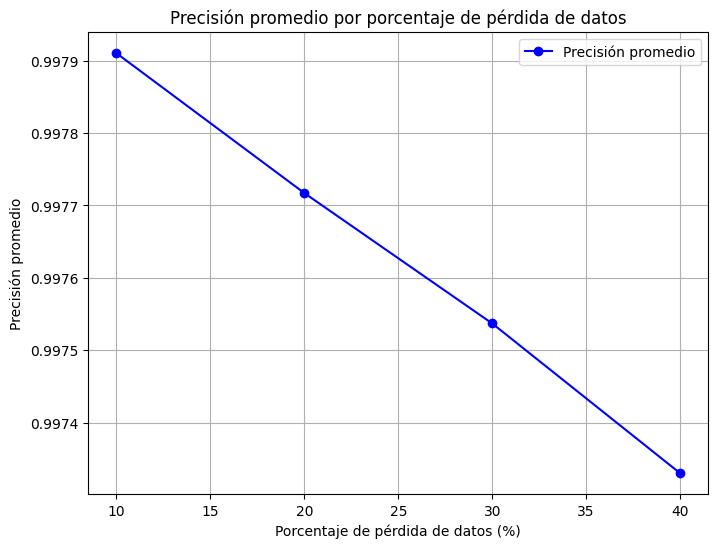

In [21]:
#Se añade un plotting al modelo original
# Extraer los porcentajes y las precisiones promedio del diccionario accuracy_summary
percentages = [perc * 100 for perc in accuracy_summary.keys()]
accuracies = [acc for acc in accuracy_summary.values()]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(percentages, accuracies, marker='o', linestyle='-', color='b', label='Precisión promedio')

# Personalizar el gráfico
plt.title('Precisión promedio por porcentaje de pérdida de datos')
plt.xlabel('Porcentaje de pérdida de datos (%)')
plt.ylabel('Precisión promedio')
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()

#### Guardar modelo

In [22]:
attention_model.save('../models/SCADA_original/SCADA_yeast.keras')  # change previous HDF5 file to keras